In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
import tensorflow as tf
import skimage.io as skio
tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__

'1.0.1'

In [2]:
def int64_feature(value):
    """Wrapper for inserting int64 features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def float_feature(value):
    """Wrapper for inserting float features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [3]:
gt = sio.loadmat('../data/sythtext/gt.mat')
print gt.keys()

['wordBB', 'txt', '__header__', '__globals__', '__version__', 'imnames', 'charBB']


In [4]:
imnames = gt['imnames']
wordBB = gt['wordBB']
charBB = gt['charBB']
txt = gt['txt']
NUMoffolder = 1
data_path = '../data/sythtext/'
os.chdir(data_path)

In [26]:
"""
def _convert_to_example(image_data, shape, bbox, label):
    ymin = bbox[:, 0].tolist()
    xmin = bbox[:, 1].tolist()
    ymax = bbox[:, 2].tolist()
    xmax = bbox[:, 3].tolist()
    numbox =bbox.shape[0]
    print 'shape: {}, height:{}, width:{}'.format(shape,shape[0],shape[1])
    example = tf.train.Example(features=tf.train.Features(feature={
            'height': int64_feature(shape[0]),
            'width': int64_feature(shape[1]),
            'channels': int64_feature(shape[2]),
            'shape': bytes_feature(shape.tostring()),
            'xmin': float_feature(xmin),
            'xmax': float_feature(xmax),
            'ymin': float_feature(ymin),
            'ymax': float_feature(ymax),
            'numbox': int64_feature(numbox),
            'label': int64_feature(label),
            'image': bytes_feature(image_data.tostring())
            }))
    return example
"""

def _convert_to_example(image_data, shape, bbox, label):
    nbbox = np.array(bbox)
    ymin = list(nbbox[:, 0])
    xmin = list(nbbox[:, 1])
    ymax = list(nbbox[:, 2])
    xmax = list(nbbox[:, 3])

    print 'shape: {}, height:{}, width:{}'.format(shape,shape[0],shape[1])
    example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': int64_feature(shape[0]),
            'image/width': int64_feature(shape[1]),
            'image/channels': int64_feature(shape[2]),
            'image/shape': int64_feature(shape),
            'image/object/bbox/xmin': float_feature(xmin),
            'image/object/bbox/xmax': float_feature(xmax),
            'image/object/bbox/ymin': float_feature(ymin),
            'image/object/bbox/ymax': float_feature(ymax),
            'image/object/bbox/label': int64_feature(label),
            'image/encoded': bytes_feature(image_data.tostring())
            }))
    return example

In [24]:
"""
def _processing_image(wordbb, imname):
    image = np.array(Image.open(imname))
    shape = image.shape
    if(len(wordbb.shape) < 3 ):
        numofbox = 1
    else:
        numofbox = wordbb.shape[2]
    bbox = []
    [xmin, ymin]= np.min(wordbb,1)
    [xmax, ymax] = np.max(wordbb,1)
    if numofbox > 1:
        bbox = [[ymin[i]/shape[0],xmin[i]/shape[1],ymax[i]/shape[0],xmax[i]/shape[1]] for i in range(numofbox)] 
    if numofbox == 1:
        bbox = [[ymin/shape[0],xmin/shape[1],ymax/shape[0],xmax/shape[1]]]
    bbox = np.array(bbox)
    label = [1 for i in range(numofbox)]
    shape = np.array(shape)
    return image, shape, bbox, label
"""



def _processing_image(wordbb, imname):
    image_data = np.array(Image.open(imname))
    shape = image.shape
    if(len(wordbb.shape) < 3 ):
        numofbox = 1
    else:
        numofbox = wordbb.shape[2]
    bbox = []
    [xmin, ymin]= np.min(wordbb,1)
    [xmax, ymax] = np.max(wordbb,1)
    if numofbox > 1:
        bbox = [[ymin[i]/shape[0],xmin[i]/shape[1],ymax[i]/shape[0],xmax[i]/shape[1]] for i in range(numofbox)] 
    if numofbox == 1:
        bbox = [[ymin/shape[0],xmin/shape[1],ymax/shape[0],xmax/shape[1]]]
    label = [1 for i in range(numofbox)]
    shape = list(shape)
    return image_data, shape, bbox, label

1/ant+hill_10_89.jpg
20
278 387 342 408


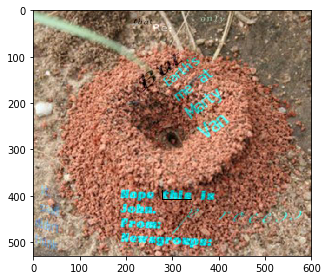

In [8]:
## Test _processing_image
j = 558650
wordbb = wordBB[0,j]
imname = imnames[0,j][0]
print imname
image, shape, bbox, label = _processing_image(wordbb, imname)
#skio.imshow(image)

print len(label)
xmin = int(bbox[14,1]*shape[1])
ymin = int(bbox[14,0]*shape[0])
xmax = int(bbox[14,3]*shape[1])
ymax = int(bbox[14,2]*shape[0])
print xmin,ymin,xmax,ymax
skio.imshow(cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,0,0)))

In [27]:
for i in range(NUMoffolder):
    tf_filename = str(i+1) + '.tfrecord'
    tfrecord_writer = tf.python_io.TFRecordWriter(tf_filename)
    dir = i+1
    pattern = re.compile(r'^{}\/'.format(dir))
    res =[k for k in range(imnames.shape[1]) if pattern.match(imnames[0,k][0]) != None ]
    print len(res)
    # shuffle
    res = np.random.permutation(res)
    print res[0:10]
    for j in res:
        wordbb = wordBB[0,j]
        imname = imnames[0,j][0]
        image_data, shape, bbox, label = _processing_image(wordbb, imname)
        example = _convert_to_example(image_data, shape, bbox, label)
        tfrecord_writer.write(example.SerializeToString())
    print 'Transform to tfrecord finished'

4262
[559447 560283 560581 561281 562560 559571 560295 559401 561415 561369]
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600
shape: [530, 600, 3], height:530, width:600

KeyboardInterrupt: 

In [21]:
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, tfrecord_serialized = reader.read(filename_queue)
    features = tf.parse_single_example(tfrecord_serialized,
    features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'channels': tf.FixedLenFeature([], tf.int64),
        'shape': tf.FixedLenFeature([], tf.string),
        'xmin': tf.FixedLenFeature([], tf.float32),
        'ymin': tf.FixedLenFeature([], tf.float32),
        'xmax': tf.FixedLenFeature([], tf.float32),
        'ymax': tf.FixedLenFeature([], tf.float32),
        'label': tf.FixedLenFeature([], tf.int64),
        'image': tf.FixedLenFeature([], tf.string),
    })
    image = tf.decode_raw(features['image'], tf.uint8)
    shape = tf.decode_raw(features['shape'], tf.uint8)
    #xmin = tf.decode_raw(features['xmin'], tf.uint8)
    #ymin = tf.decode_raw(features['ymin'], tf.uint8)
    #xmax = tf.decode_raw(features['xmax'], tf.uint8)
    #ymax = tf.decode_raw(features['ymax'], tf.uint8)
    xmin = tf.cast(features['xmin'], tf.float32)
    ymin = tf.cast(features['ymin'], tf.float32)
    xmax = tf.cast(features['xmax'], tf.float32)
    ymax = tf.cast(features['ymax'], tf.float32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    image = tf.reshape(image, tf.pack([height,width,3]))
    shape = tf.reshape(image, tf.pack([3]))
    image = tf.image.resize_image_with_crop_or_pad(image=image,
                                                  target_height= 300,
                                                  target_width = 300)
    
    
    images = tf.train.shuffle_batch([image],
                                                                    batch_size = 2,
                                                                    capacity = 30,
                                                                    num_threads = 2,
                                                                    min_after_dequeue = 10)

    return images #, shapes, xmins,ymins,xmaxs,ymaxs

In [30]:
data_dir = '/Users/xiaodiu/Documents/github/projecttextbox/TextBoxes-TensorFlow/data/sythtext/'
file_name = data_dir + '1.tfrecord'
print file_name
tfrecord_file_queue = tf.train.string_input_producer([file_name] ,num_epochs = 200,shuffle = True)
images = read_and_decode(tfrecord_file_queue)
# , shapes, xmins,ymins,xmaxs,ymaxs
init_op = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op)
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(2):
        #image, shape, xmin,ymin,xmax,ymax = sess.run([images, shapes, xmins,ymins,xmaxs,ymaxs])
        image = sess.run(images)
        try:
            
            while True:
                example = sess.run([image])
        except tf.errors.OutOfRangeError, e:
            continue
            coord.request_stop(e)
        print image[0,:,:,:].shape
        skio.imshow(image[0,:,:,:])
        skio.show()
        #print 'shape: %s' % (shape)
        #print 'xmin_shape: %s' % (xmin.shape)
    coord.request_stop()
    coord.join(threads)

/Users/xiaodiu/Documents/github/projecttextbox/TextBoxes-TensorFlow/data/sythtext/1.tfrecord
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, Name: <unknown>, Feature: channels is required but could not be found.
	 [[Node: ParseSingleExample_5/ParseExample/ParseExample = ParseExample[Ndense=10, Nsparse=0, Tdense=[DT_INT64, DT_INT64, DT_STRING, DT_INT64, DT_STRING, DT_INT64, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], dense_shapes=[[], [], [], [], [], [], [], [], [], []], sparse_types=[], _device="/job:localhost/replica:0/task:0/cpu:0"](ParseSingleExample_5/ExpandDims, ParseSingleExample_5/ParseExample/ParseExample/names, ParseSingleExample_5/ParseExample/ParseExample/dense_keys_0, ParseSingleExample_5/ParseExample/ParseExample/dense_keys_1, ParseSingleExample_5/ParseExample/ParseExample/dense_keys_2, ParseSingleExample_5/ParseExample/ParseExample/dense_keys_3, ParseSingleExample_5/ParseExample/ParseExample/dense_keys_4,

OutOfRangeError: RandomShuffleQueue '_109_shuffle_batch_5/random_shuffle_queue' is closed and has insufficient elements (requested 2, current size 0)
	 [[Node: shuffle_batch_5 = QueueDequeueMany[_class=["loc:@shuffle_batch_5/random_shuffle_queue"], component_types=[DT_UINT8], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_5/random_shuffle_queue, shuffle_batch_5/n)]]

Caused by op u'shuffle_batch_5', defined at:
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-96a00ab5111c>", line 5, in <module>
    images = read_and_decode(tfrecord_file_queue)
  File "<ipython-input-21-7f5dc53458ae>", line 40, in read_and_decode
    min_after_dequeue = 10)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/training/input.py", line 917, in shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/ops/data_flow_ops.py", line 458, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1099, in _queue_dequeue_many
    timeout_ms=timeout_ms, name=name)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): RandomShuffleQueue '_109_shuffle_batch_5/random_shuffle_queue' is closed and has insufficient elements (requested 2, current size 0)
	 [[Node: shuffle_batch_5 = QueueDequeueMany[_class=["loc:@shuffle_batch_5/random_shuffle_queue"], component_types=[DT_UINT8], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_5/random_shuffle_queue, shuffle_batch_5/n)]]


In [ ]:
FILE_PATTERN = 'voc_2012_%s.tfrecord'
ITEMS_TO_DESCRIPTIONS = {
    'image': 'A color image of varying height and width.',
    'shape': 'Shape of the image',
    'object/bbox': 'A list of bounding boxes, one per each object.',
    'object/label': 'A list of labels, one per each object.',
    'numbox': 'numbox',
}
SPLITS_TO_SIZES = {
    'train': 4262,
}
NUM_CLASSES = 2
def get_split(split_name, dataset_dir, file_pattern, reader,
              split_to_sizes, items_to_descriptions, num_classes):
    """Gets a dataset tuple with instructions for reading Pascal VOC dataset.

    Args:
      split_name: A train/test split name.
      dataset_dir: The base directory of the dataset sources.
      file_pattern: The file pattern to use when matching the dataset sources.
        It is assumed that the pattern contains a '%s' string so that the split
        name can be inserted.
      reader: The TensorFlow reader type.

    Returns:
      A `Dataset` namedtuple.

    Raises:
        ValueError: if `split_name` is not a valid train/test split.
    """
    if split_name not in split_to_sizes:
        raise ValueError('split name %s was not recognized.' % split_name)
    file_pattern = os.path.join(dataset_dir, file_pattern % split_name)

    # Allowing None in the signature so that dataset_factory can use the default.
    if reader is None:
        reader = tf.TFRecordReader
    # Features in Pascal VOC TFRecords.
    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='jpeg'),
        'image/height': tf.FixedLenFeature([1], tf.int64),
        'image/width': tf.FixedLenFeature([1], tf.int64),
        'image/channels': tf.FixedLenFeature([1], tf.int64),
        'image/shape': tf.FixedLenFeature([3], tf.int64),
        'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/label': tf.VarLenFeature(dtype=tf.int64),
        'image/object/bbox/difficult': tf.VarLenFeature(dtype=tf.int64),
        'image/object/bbox/truncated': tf.VarLenFeature(dtype=tf.int64),
    }
    items_to_handlers = {
        'image': slim.tfexample_decoder.Image('image/encoded', 'image/format'),
        'shape': slim.tfexample_decoder.Tensor('image/shape'),
        'object/bbox': slim.tfexample_decoder.BoundingBox(
                ['xmin', 'ymin', 'xmax', 'ymax'], 'image/object/bbox/'),
        'object/label': slim.tfexample_decoder.Tensor('image/object/bbox/label'),
        'object/difficult': slim.tfexample_decoder.Tensor('image/object/bbox/difficult'),
        'object/truncated': slim.tfexample_decoder.Tensor('image/object/bbox/truncated'),
    }
    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)

    labels_to_names = None
    if dataset_utils.has_labels(dataset_dir):
        labels_to_names = dataset_utils.read_label_file(dataset_dir)
    # else:
    #     labels_to_names = create_readable_names_for_imagenet_labels()
    #     dataset_utils.write_label_file(labels_to_names, dataset_dir)

    return slim.dataset.Dataset(
            data_sources=file_pattern,
            reader=reader,
            decoder=decoder,
            num_samples=split_to_sizes[split_name],
            items_to_descriptions=items_to_descriptions,
            num_classes=num_classes,
            labels_to_names=labels_to_names)

In [32]:
import tensorflow as tf

X = [[1, 2],
     [3, 4],
     [5, 6]]


def _int_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def dump_tfrecord(data, out_file):
    writer = tf.python_io.TFRecordWriter(out_file)
    for x in data:
        example = tf.train.Example(
            features=tf.train.Features(feature={
                'x': _int_feature(x)
            })
        )
        writer.write(example.SerializeToString())
    writer.close()


def load_tfrecord(file_name):
    features = {'x': tf.FixedLenFeature([2], tf.int64)}
    data = []
    for s_example in tf.python_io.tf_record_iterator(file_name):
        example = tf.parse_single_example(s_example, features=features)
        data.append(tf.expand_dims(example['x'], 0))
    return tf.concat(0, data)


if __name__ == "__main__":
    dump_tfrecord(X, 'test_tfrecord')
    print('dump ok')
    data = load_tfrecord('test_tfrecord')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Y = sess.run([data])
        print(Y)


dump ok
[array([[1, 2],
       [3, 4],
       [5, 6]])]


[u'long\nsome\nThe ' u'Inc           ' u'used,         ' u'If you        '
 u'the           ']
[u'1/ant+hill_114_11.jpg']
[[  4.55802673e+02   5.40044983e+02   5.38127747e+02   4.53885437e+02]
 [ -3.69688034e-01   1.19493160e+01   2.50601101e+01   1.27411060e+01]]
(2, 4, 8)
['long\nsome\nThe ', 'Inc           ', 'used,         ', 'If you        ', 'the           ']


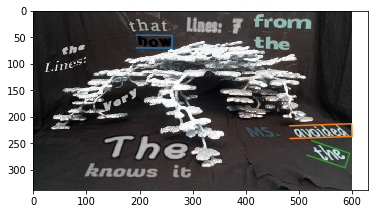

In [196]:
labels = gt['gt_test2']
txt_test = labels['txt_test']
imnames_test = labels['imnames_test']
wordBB_test = labels['wordBB_test']
charBB_test = labels['charBB_test']
print txt_test[0][0][0,res[100]]
print imnames_test[0][0][0,1000]
print wordBB_test[0][0][0,res[100]][:,:,0]
print wordBB_test[0][0][0,res[100]].shape
new_txt = [str(i) for i in txt_test[0][0][0,res[100]]]
print new_txt
img1_0 = cv2.imread('../data/sythtext/1/ant+hill_114_11.jpg')

plt.imshow(img1_0)
plt.plot(wordBB_test[0][0][0,1000][0,:,0],wordBB_test[0][0][0,1000][1,:,0])
plt.plot(wordBB_test[0][0][0,1000][0,:,1],wordBB_test[0][0][0,1000][1,:,1])
plt.plot(wordBB_test[0][0][0,1000][0,:,2],wordBB_test[0][0][0,1000][1,:,2])
plt.show()

In [146]:
[xmin, ymin]= np.min(wordBB_test[0][0][0,1000],1)
print xmin.shape
[xmax, ymax] = np.max(wordBB_test[0][0][0,1000],1)
bbox = [[ymin[i],xmin[i],ymax[i],ymin[i]] for i in range(xmin.shape[0])]
[ymin,xmin ]= np.array(bbox)[:,0:2]
xmin == xmin
#plt.imshow(cv2.rectangle(img1_0,(xmin[2],ymin[2]),(xmax[2],ymax[2]),(255,0,0)))

(15,)


ValueError: too many values to unpack

In [63]:
bboxes = tf.constant(np.transpose(np.array([ymin,xmin,ymax,xmax])),dtype=tf.float32)
bboxes.dtype
bboxes
img = tf.constant(img1_0)
resized, bboxs = tf_image.resize_image_bboxes_with_crop_or_pad(img1_0,bboxes,300,300)
resized = tf_image.resize_image(img,[300,300])
dst_image = img
resized_image = tf.image.resize_images(img, [300,300])

(388.18564, 51.4664)


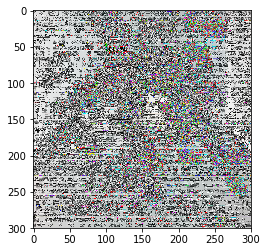

In [73]:
sess = tf.Session()
img = sess.run(resized)
bbox = sess.run(bboxs)
#plt.imshow(img)
print (bbox[0,1],bbox[0,0])
plt.imshow(cv2.rectangle(img,(bbox[0,1],bbox[0,0]),(bbox[0,3],bbox[0,2]),(255,0,0)))
sess.close()

In [128]:
image = tf.constant(img1_0,dtype=tf.float32)
bboxes = tf.constant(np.transpose(np.array([ymin/340,xmin/601,ymax/340,xmax/601])),dtype=tf.float32)
bounding_boxes = tf.expand_dims(bboxes,0)
bounding_boxes = tf.expand_dims(bounding_boxes,0)
bounding_boxes
begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(
    tf.shape(image),
    bounding_boxes=bounding_boxes)

# Draw the bounding box in an image summary.
image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(image, 0),
                                              bbox_for_draw)
image_with_box

<tf.Tensor 'DrawBoundingBoxes_15:0' shape=(1, 338, 600, 3) dtype=float32>

[[[-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]
  ..., 
  [-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]]

 [[-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]
  ..., 
  [-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]]

 [[-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]
  ..., 
  [-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]]

 ..., 
 [[-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]
  ..., 
  [-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]]

 [[-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]
  ..., 
  [-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]]

 [[-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]
  ..., 
  [-123. -117. -104.]
  [-123. -117. -104.]
  [-123. -117. -104.]]]
[[ 0.26232633  0.51458144  0.45078325  0.77807009]
 [ 0.6120556   0.17487252  0.81551802  0.78391665]
 [ 0.0348709   0.86571532  0.16536084  

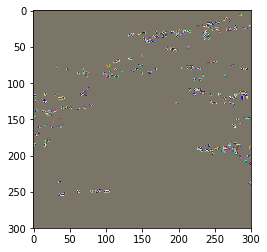

In [127]:
image = tf.constant(img1_0,dtype=tf.float32)
labels = np.arange(0,15)
bboxes = tf.constant(np.transpose(np.array([ymin/340,xmin/601,ymax/340,xmax/601])),dtype=tf.float32)
bounding_boxes = tf.expand_dims(bboxes,0)
image,labels,bboxes = ssd_vgg_preprocessing.preprocess_for_train(image, labels, bboxes,[300,300])

sess = tf.Session()
img = sess.run(image)
bboxes = sess.run(bboxes)
print img
print bboxes
print labels
plt.imshow(img)
sess.close()

(201, 205, 3)


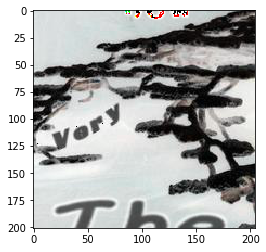

In [134]:
BBOX_CROP_OVERLAP = 0.4        # Minimum overlap to keep a bbox after cropping.
CROP_RATIO_RANGE = (0.8, 1.2)  # Distortion ratio during cropping.
EVAL_SIZE = (300, 300)
image = tf.constant(img1_0,dtype=tf.float32)
labels = np.arange(0,15)
bboxes = tf.constant(np.transpose(np.array([ymin/340,xmin/601,ymax/340,xmax/601])),dtype=tf.float32)
bounding_boxes = tf.expand_dims(bboxes,0)
dst_image, labels, bboxes, distort_bbox = \
    ssd_vgg_preprocessing.distorted_bounding_box_crop(image, labels, bboxes,
                                aspect_ratio_range=CROP_RATIO_RANGE)
sess = tf.Session()
img = sess.run(dst_image)
bboxes = sess.run(bboxes)
plt.imshow(img)
print img.shape
sess.close()

In [107]:
### Text boxes
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'pool6']
# in percent %
min_ratio = 20
max_ratio = 95
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
print step
min_sizes = []
max_sizes = []
for ratio in xrange(min_ratio, max_ratio + 1, step):
  min_sizes.append(min_dim * ratio / 100.)
  max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 10 / 100.] + min_sizes
max_sizes = [[]] + max_sizes
aspect_ratios = [[2,3,5,7,10], [2,3,5,7,10], [2,3,5,7,10], [2,3,5,7,10], [2,3,5,7,10], [2,3,5,7,10]]
# L2 normalize conv4_3.
normalizations = [20, -1, -1, -1, -1, -1]
print min_sizes
print max_sizes

18
[30.0, 60.0, 114.0, 168.0, 222.0, 276.0]
[[], 114.0, 168.0, 222.0, 276.0, 330.0]


In [7]:
img_shape=(300, 300),
num_classes=21,
no_annotation_label=21,
feat_layers=['block4', 'block7', 'block8', 'block9', 'block10', 'block11'],
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)],
anchor_size_bounds=[0.15, 0.90],
# anchor_size_bounds=[0.20, 0.90],
anchor_sizes=[(21., 45.),
              (45., 99.),
              (99., 153.),
              (153., 207.),
              (207., 261.),
              (261., 315.)],
# anchor_sizes=[(30., 60.),
#               (60., 111.),
#               (111., 162.),
#               (162., 213.),
#               (213., 264.),
#               (264., 315.)],
anchor_ratios=[[2, .5],
               [2, .5, 3, 1./3],
               [2, .5, 3, 1./3],
               [2, .5, 3, 1./3],
               [2, .5],
               [2, .5]],
anchor_steps=[8, 16, 32, 64, 100, 300],
anchor_offset=0.5,
normalizations=[20, -1, -1, -1, -1, -1],
prior_scaling=[0.1, 0.1, 0.2, 0.2]

In [137]:

with tf.name_scope("Scope_A"):
    a = tf.add(1, 2, name="A_add")
    b = tf.mul(a, 3, name="A_mul")

with tf.name_scope("Scope_B"):
    c = tf.add(4, 5, name="B_add")
    d = tf.mul(c, 6, name="B_mul")

e = tf.add(b, d, name="output")
print e.eval()

63


In [ ]:
import datasets.sythtextprovider as sythtext
import tensorflow as tf
slim = tf.contrib.slim


with tf.Session() as sess:
    data_dir = '/Users/xiaodiu/Documents/github/projecttextbox/TextBoxes-TensorFlow/data/sythtext/1.tfrecord'
    filename_queue = tf.train.string_input_producer([data_dir])
    print filename_queue
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    print serialized_example
    features = tf.parse_single_example(serialized_example,
    features={
        'image/encoded': tf.FixedLenFeature([], tf.string, default_value=''),
        'image/height': tf.FixedLenFeature([1], tf.int64),
        'image/width': tf.FixedLenFeature([1], tf.int64),
        'image/channels': tf.FixedLenFeature([1], tf.int64),
        'image/shape': tf.FixedLenFeature([3], tf.int64),
        'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/label': tf.VarLenFeature(dtype=tf.int64)
    })
    print features['image/encoded']
    image = tf.decode_raw(features['image/encoded'], tf.uint8)
    height = tf.cast(features['image/height'], tf.int64)
    width = tf.cast(features['image/width'], tf.int64)
    shape = tf.cast(features['image/shape'], tf.int64)
    
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #height, width = sess.run(height), sess.run(width)
    image = tf.reshape(image, shape)
    shape = sess.run(shape)
    
    print shape
    print sess.run(image).shape
    coord.request_stop()
    coord.join(threads)

In [5]:
img1_0 = cv2.imread('../data/sythtext/1/ant+hill_114_11.jpg')
print img1_0.shape[0]

338


In [11]:
tf.train.Feature(int64_list=tf.train.Int64List(value = [270]))

int64_list {
  value: 270
}

file_path: /Users/xiaodiu/Documents/github/projecttextbox/TextBoxes-TensorFlow/data/sythtext/*.tfrecord
image: Tensor("case_7/If_2/Merge:0", shape=(?, ?, 3), dtype=uint8)
shape: Tensor("Reshape_42:0", shape=(3,), dtype=int64)
label: Tensor("SparseToDense_7:0", shape=(?,), dtype=int64)
bboxes: Tensor("transpose_7:0", shape=(?, 4), dtype=float32)
[600 600   3]
[[ 0.42073303  0.68740213  0.58724558  0.82534337]
 [ 0.5820291   0.77937424  0.6869446   0.87098634]
 [ 0.57825273  0.84811682  0.63814181  0.91863567]
 [ 0.3562713   0.85061246  0.48362029  0.9579587 ]
 [ 0.48954248  0.88439506  0.64020807  1.00193155]
 [ 0.64087749  0.94261086  0.67172229  0.99788612]
 [ 0.545304    0.4096618   0.71068335  0.60754907]
 [ 0.46441656  0.40772533  0.56112909  0.49561128]
 [ 0.41231802  0.43048286  0.54577249  0.5562405 ]
 [ 0.64395738  0.34543678  0.69722837  0.41648671]
 [ 0.01978204 -0.00542171  0.20196398  0.12388983]
 [ 0.25491378  0.00718466  0.49360317  0.11199922]
 [ 0.07278641  0.10310369  

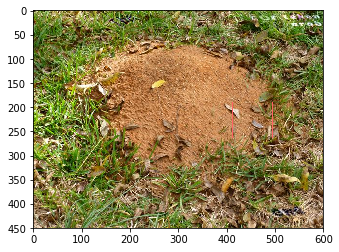

In [27]:
import datasets.sythtextprovider as sythtext
import tensorflow as tf
slim = tf.contrib.slim
import cv2
import matplotlib.pyplot as plt


data_dir = '/Users/xiaodiu/Documents/github/projecttextbox/TextBoxes-TensorFlow/data/sythtext/'
datasets = sythtext.get_datasets(data_dir,file_pattern = '*.tfrecord')
print datasets
provider = slim.dataset_data_provider.DatasetDataProvider(datasets)
# Get for SSD network: image, labels, bboxes.
[image, shape, glabels, gbboxes] = provider.get(['image', 'shape',
                                             'object/label',
                                             'object/bbox'])


def read_from_tfrecord(filenames):
    tfrecord_file_queue = tf.train.string_input_producer(filenames, name='queue')
    reader = tf.TFRecordReader()
    _, tfrecord_serialized = reader.read(tfrecord_file_queue)
    tfrecord_features = tf.parse_single_example(tfrecord_serialized,
    features={
    'label': tf.FixedLenFeature([], tf.string),
    'shape': tf.FixedLenFeature([], tf.string),
    'image': tf.FixedLenFeature([], tf.string),
    }, name='features')
    # image was saved as uint8, so we have to decode as uint8.
    image = tf.decode_raw(tfrecord_features['image'], tf.uint8)
    shape = tf.decode_raw(tfrecord_features['shape'], tf.int32)
    image = tf.reshape(image, shape)
    label = tf.cast(tfrecord_features['label'], tf.string)
    return label, shape, image

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    print sess.run(shape)
    img = sess.run(image)
    bbox =  sess.run(gbboxes)
    print bbox
    shape = img.shape
    print shape

    
    coord.request_stop()
    coord.join(threads)
    
plt.imshow(img)
plt.imshow(cv2.rectangle(img,(int(bbox[0,1]*shape[1]),int(bbox[0,0]*shape[0])),
                         (int(bbox[0,3]*shape[1]),int(bbox[0,2]*shape[0])),(255,100,100)))
plt.show()